In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from tqdm.notebook import tqdm
import pandas as pd


In [2]:
base_dir = './'
train_clean_dir = base_dir + 'train/clean/'
train_noisy_dir = base_dir + 'train/noisy/'
val_clean_dir = base_dir + 'val/clean/'
val_noisy_dir = base_dir + 'val/noisy/'
size = 80  # spectrgram width in pixels

In [3]:
def load_files_list(directory):
    """ load files list from directory tree """
    files_list = []
    speakers = os.listdir(directory)
    for speaker in speakers:
        if os.path.isdir(directory + speaker):
            files = os.listdir(directory + speaker)
            for f in files:
                if os.path.isfile(directory + speaker + '/' + f):
                    files_list.append(directory + speaker + '/' + f)
    return files_list

In [4]:
def load_file(fname):
    """ load npy file with spectrogram, cut it on sizeXsize batch """
    data = np.load(fname).T.astype(float)
    X = None
    if data.shape[1] >= size:
        X = data[0:size,0:size].reshape((1,size,size,1))
        for i in range(1, data.shape[1] // size):
            cut = data[0:size,i*size:(i+1)*size].reshape((1,size,size,1))
            X = np.concatenate((X, cut), axis=0)
    return X

In [5]:
def load_set(files):
    """ load dataset """
    split = 500
    big_loop = len(files) // split
    set_X = load_file(files[-1])
    for i in tqdm(range(big_loop)):
        tmp_X = load_file(files[i*split])
        for j in range(1, split):
            X = load_file(files[i*split+j])
            if X is not None:
                tmp_X = np.concatenate((tmp_X, X), axis=0)
        set_X = np.concatenate((set_X, tmp_X), axis=0)
        
    return set_X

In [6]:
train_clean_files = load_files_list(train_clean_dir)
train_noisy_files = load_files_list(train_noisy_dir)
val_clean_files = load_files_list(val_clean_dir)
val_noisy_files = load_files_list(val_noisy_dir)
print(f'found {len(train_clean_files)} clean train files, {len(train_noisy_files)} noisy train files')
print(f'{len(val_clean_files)} test clean files, {len(val_noisy_files)} test noisy files')

found 12000 clean train files, 12000 noisy train files
2000 test clean files, 2000 test noisy files


In [7]:
# load train dataset and check dimensions
train_X = load_set(train_noisy_files)
train_y = load_set(train_clean_files)
train_X.shape, train_y.shape

((108023, 80, 80, 1), (108023, 80, 80, 1))

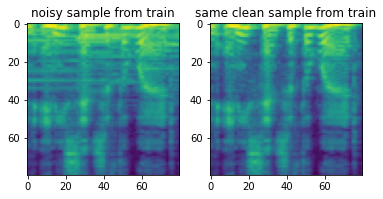

In [12]:
i = random.randint(0, train_X.shape[0])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(train_X[i,:,:,0])
ax[0].set_title('noisy sample from train')
ax[1].imshow(train_y[i,:,:,0])
ax[1].set_title('same clean sample from train')
plt.show()

In [11]:
# load test dataset and check dimensions
val_X = load_set(val_noisy_files)
val_y = load_set(val_clean_files)
val_X.shape, val_y.shape

((17917, 80, 80, 1), (17917, 80, 80, 1))

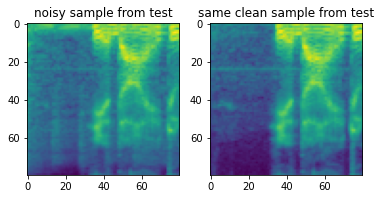

In [13]:
i = random.randint(0, val_X.shape[0])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(val_X[i,:,:,0])
ax[0].set_title('noisy sample from test')
ax[1].imshow(val_y[i,:,:,0])
ax[1].set_title('same clean sample from test')
plt.show()

In [14]:
def make_nn():
    model = tf.keras.Sequential([
        Conv2D(16, (3,3), input_shape=(size,size,1), activation='relu', padding='same', strides=2),
        Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
        Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
        Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2),
        Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2),
        Conv2DTranspose(16, (3,3), activation='relu', padding='same', strides=2),
        Conv2DTranspose(1, (3,3), activation='relu', padding='same'),
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

In [15]:
model = make_nn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 40, 40, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 80, 80, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 80, 80, 1)         1

In [16]:
early_stopping = EarlyStopping(patience=4, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
h = model.fit(train_X, train_y, batch_size=64, epochs=30, validation_split=0.1, callbacks=[reduce_lr, early_stopping])

Epoch 1/30
1520/1520 [==============================] - 20s 13ms/step - loss: 0.0934 - mse: 0.0934 - val_loss: 0.0968 - val_mse: 0.0968
Epoch 2/30
1520/1520 [==============================] - 19s 13ms/step - loss: 0.0837 - mse: 0.0837 - val_loss: 0.0937 - val_mse: 0.0937
Epoch 3/30
1520/1520 [==============================] - 19s 13ms/step - loss: 0.0821 - mse: 0.0821 - val_loss: 0.0911 - val_mse: 0.0911
Epoch 4/30
1520/1520 [==============================] - 19s 13ms/step - loss: 0.0812 - mse: 0.0812 - val_loss: 0.0910 - val_mse: 0.0910
Epoch 5/30
1520/1520 [==============================] - 19s 13ms/step - loss: 0.0805 - mse: 0.0805 - val_loss: 0.0895 - val_mse: 0.0895
Epoch 6/30
1520/1520 [==============================] - 19s 13ms/step - loss: 0.0800 - mse: 0.0800 - val_loss: 0.0888 - val_mse: 0.0888
Epoch 7/30
1520/1520 [==============================] - 19s 13ms/step - loss: 0.0796 - mse: 0.0796 - val_loss: 0.0898 - val_mse: 0.0898
Epoch 8/30
1520/1520 [==========================

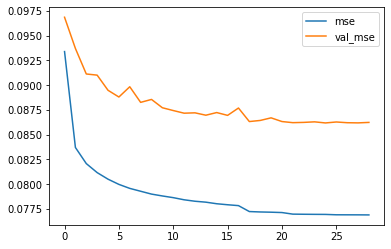

In [17]:
df = pd.DataFrame(h.history)
df.plot(y=['mse', 'val_mse'])

In [18]:
loss_test, _ = model.evaluate(val_X, val_y)
print(f'test loss = {loss_test}')

560/560 [==============================] - 2s 4ms/step - loss: 0.0781 - mse: 0.0781
test loss = 0.07808208465576172


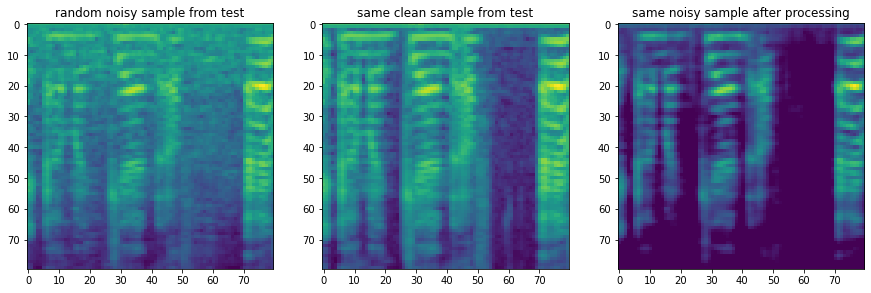

In [28]:
plt.rcParams["figure.figsize"] = (15,5)
i = random.randint(0, val_X.shape[0])
pred = model.predict(val_X[i,:,:,0].reshape(1,size,size,1))
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(val_X[i,:,:,0])
ax[0].set_title('random noisy sample from test')
ax[1].imshow(val_y[i,:,:,0])
ax[1].set_title('same clean sample from test')
ax[2].imshow(pred.reshape(size,size))
ax[2].set_title('same noisy sample after processing')
plt.show()

In [22]:
model.save('denoising.h5')